In [ ]:
!git clone --depth 1 https://github.com/IDEA-Research/DINO-X-API.git

Cloning into 'DINO-X-API'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 1), reused 15 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 5.99 MiB | 12.52 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
!pip install dds-cloudapi-sdk --upgrade

  Preparing metadata (setup.py) ... done
  Created wheel for dds-cloudapi-sdk: filename=dds_cloudapi_sdk-0.5.1-py3-none-any.whl size=18568 sha256=f874f8e092cbba3463df83761b9be6d81e684a33b70098ec5985d758d9ab5aa4
  Stored in directory: /root/.cache/pip/wheels/8a/32/b8/23f693f1a0fddf43212e63f8aa34bd4668e3c8be55cc8c7120
Successfully built dds-cloudapi-sdk


In [ ]:
%cd /content/DINO-X-API/

/content/DINO-X-API


# DEMO DINO-X

In [ ]:
! pip install --quiet -r requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.1 MB/s eta 0:00:00


In [ ]:
!pip install -q dds-cloudapi-sdk --upgrade

# Develop a Text Free Prompter Using DINO

In [ ]:
# dds cloudapi for DINO-X
from dds_cloudapi_sdk import Config
from dds_cloudapi_sdk import Client
from dds_cloudapi_sdk.tasks.v2_task import V2Task, create_task_with_local_image_auto_resize

# using supervision for visualization
import os
import cv2
import numpy as np
import supervision as sv
from pathlib import Path
from pycocotools import mask as mask_utils
from rle_util import rle_to_array

In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path
from collections import Counter

def generate_description_prompt(data):
    category_counts = Counter(obj['category'] for obj in data)
    sorted_categories = sorted(category_counts.items())

    phrases = []
    for category, count in sorted_categories:
        name = category if count == 1 else category + 's'
        phrases.append(f"{count} {name}")

    if len(phrases) == 1:
        return f"There is {phrases[0]} in the picture."
    else:
        return f"There are {', '.join(phrases[:-1])}, and {phrases[-1]} in the picture."


def DINO_X_API(API_TOKEN, IMG_PATH, OUTPUT_DIR, Visualization=False):

    # Step 1: Prepare paths
    img_path = Path(IMG_PATH)
    output_dir = Path(OUTPUT_DIR)
    output_dir.mkdir(parents=True, exist_ok=True)
    image_stem = img_path.stem  # e.g., "dog_cat"
    output_image_path = output_dir / f"{image_stem}_annotated.jpg"

    # Step 2: Set up config and client
    config = Config(API_TOKEN)
    client = Client(config)

    # Step 3: Run detection task with local image
    v2_task = create_task_with_local_image_auto_resize(
        api_path="/v2/task/dinox/detection",
        api_body_without_image={
            "model": "DINO-X-1.0",
            "prompt": {
                "type": "universal"
            },
            "targets": ["bbox", "mask"],
            "bbox_threshold": 0.25,
            "iou_threshold": 0.8
        },
        image_path=str(img_path)
    )

    client.run_task(v2_task)
    objects = v2_task.result["objects"]

    # Step 4: Optional visualization
    if Visualization and objects:
        class_names = sorted(set(obj["category"].lower().strip() for obj in objects))
        class_name_to_id = {name: idx for idx, name in enumerate(class_names)}

        boxes = [obj["bbox"] for obj in objects]
        masks = [
            rle_to_array(obj["mask"]["counts"], obj["mask"]["size"][0] * obj["mask"]["size"][1])
            .reshape(obj["mask"]["size"])
            for obj in objects
        ]
        confidences = [obj["score"] for obj in objects]
        class_ids = [class_name_to_id[obj["category"].lower().strip()] for obj in objects]

        labels = [
            f"{obj['category']} {score:.2f}" for obj, score in zip(objects, confidences)
        ]

        img = cv2.imread(str(img_path))
        detections = sv.Detections(
            xyxy=np.array(boxes),
            mask=np.array(masks).astype(bool),
            class_id=np.array(class_ids),
        )

        box_annotator = sv.BoxAnnotator()
        annotated = box_annotator.annotate(scene=img.copy(), detections=detections)

        label_annotator = sv.LabelAnnotator()
        annotated = label_annotator.annotate(scene=annotated, detections=detections, labels=labels)

        cv2.imwrite(str(output_image_path), annotated)

    # Step 5: Return prompt
    return generate_description_prompt(objects)

In [ ]:
"""
Hyper Parameters
"""
API_TOKEN = "80a84539ac481b2a3bd854c4c3fa5c02"
IMG_PATH = "./assets/demo.png"
#TEXT_PROMPT = "Is there a mouse and a car in the picture"
OUTPUT_DIR = Path("./outputs/prompt_free_detection_segmentation")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# Test run it
prompt = DINO_X_API(API_TOKEN, IMG_PATH, OUTPUT_DIR)
prompt

'There are 2 eyes, 1 helmet, 1 mouse, 1 mouth, 1 plant, 1 text, 1 vehicle, and 4 wheels in the picture.'

# Set up Llama


In [ ]:
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.3 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import BitsAndBytesConfig

In [ ]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline(
    task="image-text-to-text",
    model=model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Prompt
DINO_Prompt = "There are 2 eyes, 1 helmet, 1 mouse, 1 mouth, 1 plant, 1 text, 1 vehicle, and 4 wheels in the picture."

original_prompt = "Is there a motorcycle in the picture?"

enhanced_prompt = "From the object detector, we can see that, " + DINO_Prompt + " So based on the given information from the object detector and the orginal image, " + original_prompt

original_messages = [
     {
         "role": "user",
         "content": [
             {
                 "type": "image",
                 "image": "./assets/demo.png",
             },
             {"type": "text", "text": original_prompt},
         ],
     }
 ]

enhanced_messages = [
     {
         "role": "user",
         "content": [
             {
                 "type": "image",
                 "image": "./assets/demo.png",
             },
             {"type": "text", "text": enhanced_prompt},
         ],
     }
 ]

In [ ]:
original_outputs = pipe(text=original_messages, max_new_tokens=60, return_full_text=False)

original_outputs[0]["generated_text"]

' No, there is no motorcycle in the picture. The image features a small toy car with a mouse or a small rodent in it, wearing a helmet.'

In [ ]:
enhanced_outputs = pipe(text=enhanced_messages, max_new_tokens=60, return_full_text=False)

print(enhanced_prompt)
enhanced_outputs[0]["generated_text"]

From the object detector, we can see that, There are 2 eyes, 1 helmet, 1 mouse, 1 mouth, 1 plant, 1 text, 1 vehicle, and 4 wheels in the picture. So based on the given information from the object detector and the orginal image, Is there a motorcycle in the picture?


' No, there is no motorcycle in the picture. The image features a small mouse wearing a helmet and sitting in a toy car.'

# Build pipeline for Llama and DINO API

In [ ]:
def llama_dino_pipeline(
    API_TOKEN,
    IMG_PATH,
    OUTPUT_DIR,
    Visualization=False,
    Dino_activated=True,
    original_prompt=None,
    max_new_tokens=60,
    return_full_text=False):


    if Dino_activated:
        enhancer = DINO_X_API(API_TOKEN, IMG_PATH, OUTPUT_DIR, Visualization)

    enhanced_prompt = "From the object detector, we can see that, " + enhancer + " So based on the given information from the object detector and the orginal image, " + original_prompt

    original_messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": IMG_PATH,
                },
                {"type": "text", "text": original_prompt},
            ],
        }
    ]

    enhanced_messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": IMG_PATH,
                },
                {"type": "text", "text": enhanced_prompt},
            ],
        }
    ]

    if Dino_activated:
        messages = enhanced_messages
    else:
        messages = original_messages

    outputs = pipe(text=messages,
                    max_new_tokens=max_new_tokens,
                       return_full_text=return_full_text,
                   )

    return messages, outputs[0]["generated_text"]

In [ ]:
# Test
messages, text_result = llama_dino_pipeline(API_TOKEN=API_TOKEN,
                    IMG_PATH ="/content/drive/MyDrive/DINOX-LLAVA/val2014/COCO_val2014_000000310196.jpg",
                    OUTPUT_DIR = OUTPUT_DIR,
                    Visualization=False,
                    Dino_activated=True,
                    original_prompt ="Is there a snowboard in the image?",
                    max_new_tokens=60,
                    return_full_text=False)

print(messages)
print(text_result)



[{'role': 'user', 'content': [{'type': 'image', 'image': '/content/drive/MyDrive/DINOX-LLAVA/val2014/COCO_val2014_000000310196.jpg'}, {'type': 'text', 'text': 'From the object detector, we can see that, There are 1 helmet, 1 parka, 1 person, and 1 snowboard in the picture. So based on the given information from the object detector and the orginal image, Is there a snowboard in the image?'}]}]
 Yes, there is a snowboard in the image.


# Build functions as dataloader

In [ ]:
%cd /content/drive/MyDrive/DINOX-LLAVA

/content/drive/MyDrive/DINOX-LLAVA


In [ ]:
import json
from pathlib import Path

def load_llava_prompts_from_file(file_path, n=10):
    """
    Load the first `n` JSON lines from a file and format them for LLaVA prompting.

    Each returned item is a dict:
    {
        "question_id": ...,
        "image": ...,
        "prompt": "...",
        "label": ...
    }
    """
    prompts = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= n:
                break
            entry = json.loads(line.strip())
            prompts.append({
                "question_id": entry["question_id"],
                "image": entry["image"],
                "prompt": f'{entry["text"]}',
                "label": entry["label"].strip().lower()
            })

    return prompts


In [ ]:
data_path = "/content/drive/MyDrive/DINOX-LLAVA/coco_pope_adversarial.json"
samples = load_llava_prompts_from_file(data_path, n=2)

for s in samples:
    print(s["image"], "→", s["prompt"], "| Groundtruth:", s["label"])

COCO_val2014_000000310196.jpg → Is there a snowboard in the image? | Groundtruth: yes
COCO_val2014_000000310196.jpg → Is there a backpack in the image? | Groundtruth: no


In [ ]:
import json
from pathlib import Path
from datetime import datetime

def process_samples_and_save_json(samples, image_dir, output_dir):
    """
    Processes a list of samples using llama_dino_pipeline and saves messages/responses
    to a timestamped JSON file. Full image paths are constructed using `image_dir`.

    Args:
        samples (List[Dict]): List of question/image prompt dictionaries.
        image_dir (str or Path): Directory where image files are stored.
        output_dir (str or Path): Directory to save the result JSON file.
    """
    image_dir = Path(image_dir)
    output_dir = Path(output_dir)
    results = []

    for sample in samples:
        image_filename = sample["image"]
        image_path = image_dir / image_filename
        prompt = sample["prompt"]

        print(f"Processing Q{sample.get('question_id', '?')} - {prompt.strip()[:50]}...")

        messages, responses = llama_dino_pipeline(
            API_TOKEN,
            str(image_path),
            OUTPUT_DIR,
            Visualization=False,
            Dino_activated=True,
            original_prompt=prompt,
            max_new_tokens=60,
            return_full_text=False
        )

        results.append({
            "question_id": sample.get("question_id"),
            "image": str(image_path),
            "prompt": prompt,
            "messages": messages,
            "responses": responses
        })

    # Save result with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = output_dir / f"llava_dino_output_{timestamp}.json"
    output_dir.mkdir(parents=True, exist_ok=True)

    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    print(f"\n✅ Saved {len(results)} entries to {output_file}")


In [ ]:
output_dir = "/content/drive/MyDrive/DINOX-LLAVA/Output"
image_dir = "/content/drive/MyDrive/DINOX-LLAVA/val2014/"

process_samples_and_save_json(
    samples,
    image_dir=image_dir,
    output_dir=output_dir
)

Processing Q1 - Is there a snowboard in the image?...
Processing Q2 - Is there a backpack in the image?...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



✅ Saved 2 entries to /content/drive/MyDrive/DINOX-LLAVA/Output/llava_dino_output_20250521_195217.json


In [ ]:
import torch
torch.cuda.empty_cache()

# Batch Processing for Llava

In [ ]:
import json

def get_first_100_unique_images(file_path, n=100):
    """
    Reads a JSONL file, returns a list of the first 100 unique image names.

    Args:
        file_path (str): Path to the JSONL file.

    Returns:
        List[str]: List of 100 unique image filenames (order preserved).
    """
    image_names = []
    seen = set()
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line.strip())
            img = entry["image"]
            if img not in seen:
                image_names.append(img)
                seen.add(img)
                if len(image_names) == n:
                    break
    return image_names

In [ ]:
# Test
images = get_first_100_unique_images("/content/drive/MyDrive/DINOX-LLAVA/coco_pope_adversarial_after517.json", 200)
print(images)
print("Total images:", len(images))  # Should be 100

['COCO_val2014_000000353096.jpg', 'COCO_val2014_000000207205.jpg', 'COCO_val2014_000000427113.jpg', 'COCO_val2014_000000498374.jpg', 'COCO_val2014_000000013348.jpg', 'COCO_val2014_000000081336.jpg', 'COCO_val2014_000000190185.jpg', 'COCO_val2014_000000209755.jpg', 'COCO_val2014_000000227227.jpg', 'COCO_val2014_000000397705.jpg', 'COCO_val2014_000000287305.jpg', 'COCO_val2014_000000257327.jpg', 'COCO_val2014_000000557016.jpg', 'COCO_val2014_000000105732.jpg', 'COCO_val2014_000000534121.jpg', 'COCO_val2014_000000520524.jpg', 'COCO_val2014_000000580294.jpg', 'COCO_val2014_000000374061.jpg', 'COCO_val2014_000000094944.jpg', 'COCO_val2014_000000572075.jpg', 'COCO_val2014_000000387098.jpg', 'COCO_val2014_000000382670.jpg', 'COCO_val2014_000000414516.jpg', 'COCO_val2014_000000204360.jpg', 'COCO_val2014_000000245642.jpg', 'COCO_val2014_000000237767.jpg', 'COCO_val2014_000000370900.jpg', 'COCO_val2014_000000094501.jpg', 'COCO_val2014_000000069196.jpg', 'COCO_val2014_000000366141.jpg', 'COCO_val

In [ ]:
import json
from pathlib import Path
from tqdm import tqdm

def run_dino_and_merge_enhanced(API_TOKEN, image_dir, image_json_path, OUTPUT_DIR, output_json_path, Visualization=False, max_images=2):
    """
    1. Runs DINO_X_API on each image (first max_images unique from JSONL).
    2. Merges DINO results with the original JSONL, adding enhanced_prompt only for changed rows.
    3. Saves only changed rows to the output JSONL.
    """
    image_dir = Path(image_dir)
    OUTPUT_DIR = str(OUTPUT_DIR)
    output_json_path = Path(output_json_path)
    output_json_path.parent.mkdir(parents=True, exist_ok=True)
    image_names = get_first_100_unique_images(image_json_path, n=max_images)

    # --- DINO Processing ---
    print(f"\n🔍 Running DINO on {len(image_names)} images...")
    results = []
    for img_name in tqdm(image_names, desc="🔲 DINO Processing"):
        img_path = str(image_dir / img_name)
        try:
            prompt = DINO_X_API(API_TOKEN, img_path, OUTPUT_DIR, Visualization)
        except Exception as e:
            print(f"  ⚠️  Error processing {img_name}: {e}")
            prompt = ""
        results.append({
            "image_name": img_name,
            "prompt": prompt
        })

    dino_lookup = {r["image_name"]: r["prompt"] for r in results}

    # --- Merge with Original JSONL ---
    total_rows = 0
    changed_count = 0
    print("\n🔗 Merging prompts with original questions...")
    with open(image_json_path, "r", encoding="utf-8") as infile, \
         open(output_json_path, "w", encoding="utf-8") as outfile:
        for line in tqdm(infile, desc="🔁 Merging prompts"):
            total_rows += 1
            entry = json.loads(line)
            image_name = entry["image"]
            enhancer = dino_lookup.get(image_name, "")

            if enhancer:  # Only save changed rows
                original_prompt = entry["text"]
                enhanced_prompt = (
                    f"From the object detector, we can see that, {enhancer} "
                    f"So based on the given information from the object detector and the orginal image, {original_prompt}"
                )
                entry["enhanced_prompt"] = enhanced_prompt
                outfile.write(json.dumps(entry, ensure_ascii=False) + "\n")
                changed_count += 1

    print("\n✅ Process Summary:")
    print(f"  - Images processed by DINO: {len(image_names)}")
    print(f"  - Enhanced rows written: {changed_count}")
    print(f"  - Output file: {output_json_path}\n")


In [ ]:
import json
from pathlib import Path
from tqdm import tqdm
import datetime

def batch_llava_inference(pipe, image_paths, prompts, max_new_tokens=60, return_full_text=False, batch_size=8):
    """
    Batch-calls LLaVA pipe for lists of image_paths and prompts.
    Returns a list of results (strings).
    """
    assert len(image_paths) == len(prompts)
    all_results = []
    for start in tqdm(range(0, len(prompts), batch_size), desc="Batch LLaVA Inference", leave=True):
        batch_image_paths = image_paths[start:start+batch_size]
        batch_prompts = prompts[start:start+batch_size]
        # Compose messages for this batch
        batch_messages = [
            [{
                "role": "user",
                "content": [
                    {"type": "image", "image": img},
                    {"type": "text", "text": prm}
                ]
            }]
            for img, prm in zip(batch_image_paths, batch_prompts)
        ]
        outputs = pipe(
            text=batch_messages,
            max_new_tokens=max_new_tokens,
            return_full_text=return_full_text,
        )
        for out in outputs:
            if isinstance(out, dict) and "generated_text" in out:
                all_results.append(out["generated_text"])
            else:
                all_results.append(out)
    return all_results

def run_compare_llava_on_original_vs_enhanced(
    API_TOKEN,
    image_dir,
    image_json_path,
    OUTPUT_DIR,
    output_json_path,
    pipe,
    llava_batch_size=8,
    llava_max_new_tokens=60,
    llava_return_full_text=False,
    enhanced_jsonl_path=None,
    final_result_json_path=None,
    max_images=2,
    max_samples=None,
    Visualization=False
):
    """
    1. Runs run_dino_and_merge_enhanced.
    2. Reads enhanced JSONL, batch-processes with LLaVA for both prompts.
    3. Saves results to final_result_json_path.
    """
    # Step 1: DINO and merge
    if enhanced_jsonl_path is None:
        enhanced_jsonl_path = output_json_path
    run_dino_and_merge_enhanced(
        API_TOKEN=API_TOKEN,
        image_dir=image_dir,
        image_json_path=image_json_path,
        OUTPUT_DIR=OUTPUT_DIR,
        output_json_path=enhanced_jsonl_path,
        Visualization=Visualization,
        max_images=max_images
    )
    print("\n🟢 DINO enhancement completed. Running LLaVA comparison...")

    # Step 2: Read enhanced prompts
    with open(enhanced_jsonl_path, "r", encoding="utf-8") as f:
        data = [json.loads(line) for line in f]
    if max_samples:
        data = data[:max_samples]
    image_dir = Path(image_dir)
    images = [
        str(image_dir / entry["image"])
        if not entry["image"].startswith("/") and not entry["image"].startswith("http")
        else entry["image"]
        for entry in data
    ]
    original_prompts = [entry["text"] for entry in data]
    enhanced_prompts = [entry.get("enhanced_prompt", "") for entry in data]

    # Step 3: Batch process original prompts
    print("\n🟢 Running LLaVA on original prompts...")
    llava_results_original = batch_llava_inference(
        pipe, images, original_prompts,
        max_new_tokens=llava_max_new_tokens,
        return_full_text=llava_return_full_text,
        batch_size=llava_batch_size
    )

    # Step 4: Batch process enhanced prompts (skip if empty)
    print("\n🟢 Running LLaVA on enhanced prompts...")
    llava_results_enhanced = batch_llava_inference(
        pipe, images, enhanced_prompts,
        max_new_tokens=llava_max_new_tokens,
        return_full_text=llava_return_full_text,
        batch_size=llava_batch_size
    )

    # Step 5: Save results
    all_results = []
    for i, entry in enumerate(data):
        all_results.append({
            "image": entry["image"],
            "ground_truth": entry["label"],
            "original_prompt": original_prompts[i],
            "enhanced_prompt": enhanced_prompts[i],
            "llava_result_original": llava_results_original[i],
            "llava_result_enhanced": llava_results_enhanced[i],
        })

    if final_result_json_path is None:
        now_str = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        final_result_json_path = str(Path(output_json_path).parent / f"llava_comparison_results_{now_str}.json")

    with open(final_result_json_path, "w", encoding="utf-8") as f:
        json.dump(all_results, f, indent=2, ensure_ascii=False)
    print(f"\n✅ All results saved to: {final_result_json_path}")
    return all_results


In [ ]:
image_dir="/content/drive/MyDrive/DINOX-LLAVA/val2014"
image_json_path="/content/drive/MyDrive/DINOX-LLAVA/coco_pope_adversarial.json"
OUTPUT_DIR="/content/drive/MyDrive/DINOX-LLAVA/dino_outputs"
output_json_path="/content/drive/MyDrive/DINOX-LLAVA/dino_outputs/dino_detection_prompts.json"
max_images=100
llava_batch_size=8
llava_max_new_tokens=60
max_samples=None

results = run_compare_llava_on_original_vs_enhanced(
    API_TOKEN=API_TOKEN,
    image_dir=image_dir,
    image_json_path=image_json_path,
    OUTPUT_DIR=OUTPUT_DIR,
    output_json_path=output_json_path,
    Visualization=False,
    pipe=pipe,   # your LLaVA pipeline
    llava_batch_size=2,
    llava_max_new_tokens=60,
    max_images=max_images,
    max_samples=max_samples  # for quick testing
)

import torch
torch.cuda.empty_cache()


🔍 Running DINO on 100 images...


🔲 DINO Processing:  87%|████████▋ | 87/100 [05:17<00:35,  2.71s/it]

  ⚠️  Error processing COCO_val2014_000000353096.jpg: Failed to trigger V2Task<task_id:None, idemp_key:721e8e9758cb4db1902c235dc3afd7aa>, error: Token out of Quota


🔲 DINO Processing:  88%|████████▊ | 88/100 [05:18<00:26,  2.24s/it]

  ⚠️  Error processing COCO_val2014_000000207205.jpg: Failed to trigger V2Task<task_id:None, idemp_key:22223d714ef649f8813d21731fa7f569>, error: Token out of Quota


🔲 DINO Processing:  89%|████████▉ | 89/100 [05:19<00:20,  1.86s/it]

  ⚠️  Error processing COCO_val2014_000000427113.jpg: Failed to trigger V2Task<task_id:None, idemp_key:73aa2bdb4ff64d65a9dfac08e1224f7c>, error: Token out of Quota


🔲 DINO Processing:  90%|█████████ | 90/100 [05:20<00:16,  1.69s/it]

  ⚠️  Error processing COCO_val2014_000000498374.jpg: Failed to trigger V2Task<task_id:None, idemp_key:2134021089da4b39afe05acfa8d52d04>, error: Token out of Quota


🔲 DINO Processing:  91%|█████████ | 91/100 [05:22<00:14,  1.60s/it]

  ⚠️  Error processing COCO_val2014_000000013348.jpg: Failed to trigger V2Task<task_id:None, idemp_key:aff65e667d7a4ee78e821a9b6a4fa567>, error: Token out of Quota


🔲 DINO Processing:  92%|█████████▏| 92/100 [05:22<00:10,  1.34s/it]

  ⚠️  Error processing COCO_val2014_000000081336.jpg: Failed to trigger V2Task<task_id:None, idemp_key:77b18ef4b3ab4992abce943fd6e5a525>, error: Token out of Quota


🔲 DINO Processing:  93%|█████████▎| 93/100 [05:23<00:08,  1.24s/it]

  ⚠️  Error processing COCO_val2014_000000190185.jpg: Failed to trigger V2Task<task_id:None, idemp_key:328502bdd23243b0b3b9ba585ce737e5>, error: Token out of Quota


🔲 DINO Processing:  94%|█████████▍| 94/100 [05:24<00:06,  1.13s/it]

  ⚠️  Error processing COCO_val2014_000000209755.jpg: Failed to trigger V2Task<task_id:None, idemp_key:f335bec842db465284cb79ce8ca0c922>, error: Token out of Quota


🔲 DINO Processing:  95%|█████████▌| 95/100 [05:25<00:05,  1.04s/it]

  ⚠️  Error processing COCO_val2014_000000227227.jpg: Failed to trigger V2Task<task_id:None, idemp_key:1a93e89c2be74d88b4cb90d0e25c4997>, error: Token out of Quota


🔲 DINO Processing:  96%|█████████▌| 96/100 [05:26<00:04,  1.06s/it]

  ⚠️  Error processing COCO_val2014_000000397705.jpg: Failed to trigger V2Task<task_id:None, idemp_key:dd6bd5a42e8047ee846d2d85c6cce23e>, error: Token out of Quota


🔲 DINO Processing:  97%|█████████▋| 97/100 [05:27<00:03,  1.08s/it]

  ⚠️  Error processing COCO_val2014_000000287305.jpg: Failed to trigger V2Task<task_id:None, idemp_key:d29b1159f06844c1963e5a1f066fd99d>, error: Token out of Quota


🔲 DINO Processing:  98%|█████████▊| 98/100 [05:28<00:01,  1.03it/s]

  ⚠️  Error processing COCO_val2014_000000257327.jpg: Failed to trigger V2Task<task_id:None, idemp_key:d8ce9855f8154137a654c48d7426d44b>, error: Token out of Quota


🔲 DINO Processing:  99%|█████████▉| 99/100 [05:29<00:01,  1.04s/it]

  ⚠️  Error processing COCO_val2014_000000557016.jpg: Failed to trigger V2Task<task_id:None, idemp_key:b454c81726c14a06a985d750c27e97e6>, error: Token out of Quota


🔲 DINO Processing: 100%|██████████| 100/100 [05:30<00:00,  3.31s/it]


  ⚠️  Error processing COCO_val2014_000000105732.jpg: Failed to trigger V2Task<task_id:None, idemp_key:b94d8aa2bd0d4c84986dbeb81edc2a9c>, error: Token out of Quota

🔗 Merging prompts with original questions...


🔁 Merging prompts: 3000it [00:00, 213501.29it/s]



✅ Process Summary:
  - Images processed by DINO: 100
  - Enhanced rows written: 516
  - Output file: /content/drive/MyDrive/DINOX-LLAVA/dino_outputs/dino_detection_prompts.json


🟢 DINO enhancement completed. Running LLaVA comparison...

🟢 Running LLaVA on original prompts...


Batch LLaVA Inference: 100%|██████████| 258/258 [16:22<00:00,  3.81s/it]



🟢 Running LLaVA on enhanced prompts...


Batch LLaVA Inference: 100%|██████████| 258/258 [13:38<00:00,  3.17s/it]


✅ All results saved to: /content/drive/MyDrive/DINOX-LLAVA/dino_outputs/llava_comparison_results_2025-05-22_18-09-14.json


In [ ]:
import json

def extract_answer_from_generated_text(answer_entry):
    """
    Extract 'yes'/'no' from a LLaVA result entry (list with dict(s), as in your file).
    """
    if isinstance(answer_entry, list) and answer_entry and isinstance(answer_entry[0], dict):
        text = answer_entry[0]["generated_text"]
    else:
        text = str(answer_entry)
    # Only keep the first sentence (up to first '.')
    if '.' in text:
        text = text.split('.')[0]
    text = text.replace(',', '')
    words = text.lower().split(' ')
    if 'no' in words or 'not' in words:
        return 'no'
    else:
        return 'yes'

def print_metrics(metrics, title):
    print(f"\n{'='*20} {title} {'='*20}")
    print(f"{'TP':>3} {'FP':>3} {'TN':>3} {'FN':>3} | {'Acc':>6} {'Prec':>6} {'Recall':>6} {'F1':>6} | {'Total Questions':>5}")
    print(f"{metrics['TP']:>3} {metrics['FP']:>3} {metrics['TN']:>3} {metrics['FN']:>3} | "
          f"{metrics['Accuracy']*100:5.1f}% {metrics['Precision']*100:5.1f}% {metrics['Recall']*100:5.1f}% {metrics['F1']*100:5.1f}% | "
          f"{metrics['Total Questions']:>3}")

def print_per_question(labels, preds, prompt_type, prompts):
    print(f"\n{'Question':<50} {'GT':^7} {prompt_type:^10}")
    print('-'*70)
    for i, (l, p, prm) in enumerate(zip(labels, preds, prompts)):
        print(f"{prm[:45]:<50} {l:^7} {p:^10}")

def evaluate_llava_json(json_path, show_per_question=False):
    """
    Loads results JSON file and evaluates original/enhanced prompts against ground_truth.
    Prints a nice table of accuracy/precision/recall/F1/yes_ratio for both.
    If show_per_question=True, shows a table per-question.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    labels = [entry["ground_truth"].strip().lower() for entry in data]
    orig_prompts = [entry["original_prompt"] for entry in data]
    enh_prompts = [entry["enhanced_prompt"] for entry in data]

    llava_orig_answers = [extract_answer_from_generated_text(entry["llava_result_original"]) for entry in data]
    llava_enh_answers = [extract_answer_from_generated_text(entry["llava_result_enhanced"]) for entry in data]

    def get_metrics(preds, labels):
        label_list = [0 if l == 'no' else 1 for l in labels]
        pred_list  = [0 if a == 'no' else 1 for a in preds]

        pos, neg = 1, 0
        yes_ratio = pred_list.count(1) / len(pred_list) if len(pred_list) else 0

        TP = sum(1 for p, l in zip(pred_list, label_list) if p == pos and l == pos)
        FP = sum(1 for p, l in zip(pred_list, label_list) if p == pos and l == neg)
        TN = sum(1 for p, l in zip(pred_list, label_list) if p == neg and l == neg)
        FN = sum(1 for p, l in zip(pred_list, label_list) if p == neg and l == pos)

        precision = TP / (TP + FP) if TP + FP else 0.0
        recall = TP / (TP + FN) if TP + FN else 0.0
        f1 = 2*precision*recall / (precision + recall) if precision + recall else 0.0
        acc = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0

        return {
            'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN,
            'Accuracy': acc, 'Precision': precision,
            'Recall': recall, 'F1': f1, 'Total Questions': len(data)
        }

    print_metrics(get_metrics(llava_orig_answers, labels), "Original Prompt Evaluation")
    print_metrics(get_metrics(llava_enh_answers, labels), "Enhanced Prompt Evaluation")

    if show_per_question:
        print_per_question(labels, llava_orig_answers, "LLaVA-Orig", orig_prompts)
        print_per_question(labels, llava_enh_answers, "LLaVA-Enh", orig_prompts)

    return {
        "original": get_metrics(llava_orig_answers, labels),
        "enhanced": get_metrics(llava_enh_answers, labels),
        "labels": labels,
        "llava_result_original": llava_orig_answers,
        "llava_result_enhanced": llava_enh_answers,
    }


In [ ]:
results = evaluate_llava_json("/content/drive/MyDrive/DINOX-LLAVA/dino_outputs/llava_comparison_results_2025-05-22_18-09-14.json")


==================== Original Prompt Evaluation ====================
 TP  FP  TN  FN |    Acc   Prec Recall     F1 | Total Questions
234  82 177  23 |  79.7%  74.1%  91.1%  81.7% | 516

==================== Enhanced Prompt Evaluation ====================
 TP  FP  TN  FN |    Acc   Prec Recall     F1 | Total Questions
242  85 174  15 |  80.6%  74.0%  94.2%  82.9% | 516


In [ ]:
image_dir="/content/drive/MyDrive/DINOX-LLAVA/val2014"
image_json_path="/content/drive/MyDrive/DINOX-LLAVA/coco_pope_adversarial_after517.json"
OUTPUT_DIR="/content/drive/MyDrive/DINOX-LLAVA/dino_outputs"
output_json_path="/content/drive/MyDrive/DINOX-LLAVA/dino_outputs/dino_detection_prompts_after517.json"
max_images=200
llava_batch_size=8
llava_max_new_tokens=60
max_samples=None

results = run_compare_llava_on_original_vs_enhanced(
    API_TOKEN=API_TOKEN,
    image_dir=image_dir,
    image_json_path=image_json_path,
    OUTPUT_DIR=OUTPUT_DIR,
    output_json_path=output_json_path,
    Visualization=False,
    pipe=pipe,   # your LLaVA pipeline
    llava_batch_size=llava_batch_size,
    llava_max_new_tokens=llava_max_new_tokens,
    max_images=max_images,
    max_samples=max_samples,
)

import torch
torch.cuda.empty_cache()


🔍 Running DINO on 200 images...


🔲 DINO Processing: 100%|██████████| 200/200 [12:16<00:00,  3.68s/it]



🔗 Merging prompts with original questions...


🔁 Merging prompts: 2484it [00:00, 128801.83it/s]



✅ Process Summary:
  - Images processed by DINO: 200
  - Enhanced rows written: 1200
  - Output file: /content/drive/MyDrive/DINOX-LLAVA/dino_outputs/dino_detection_prompts_after517.json


🟢 DINO enhancement completed. Running LLaVA comparison...

🟢 Running LLaVA on original prompts...


Batch LLaVA Inference: 100%|██████████| 150/150 [37:50<00:00, 15.14s/it]



🟢 Running LLaVA on enhanced prompts...


Batch LLaVA Inference: 100%|██████████| 150/150 [32:29<00:00, 13.00s/it]


✅ All results saved to: /content/drive/MyDrive/DINOX-LLAVA/dino_outputs/llava_comparison_results_2025-05-22_20-09-50.json


In [ ]:
results = evaluate_llava_json("/content/drive/MyDrive/DINOX-LLAVA/dino_outputs/llava_comparison_results_2025-05-22_20-09-50.json")


==================== Original Prompt Evaluation ====================
 TP  FP  TN  FN |    Acc   Prec Recall     F1 | Total Questions
539 208 392  61 |  77.6%  72.2%  89.8%  80.0% | 1200

==================== Enhanced Prompt Evaluation ====================
 TP  FP  TN  FN |    Acc   Prec Recall     F1 | Total Questions
554 211 389  46 |  78.6%  72.4%  92.3%  81.2% | 1200


# Interesting finding

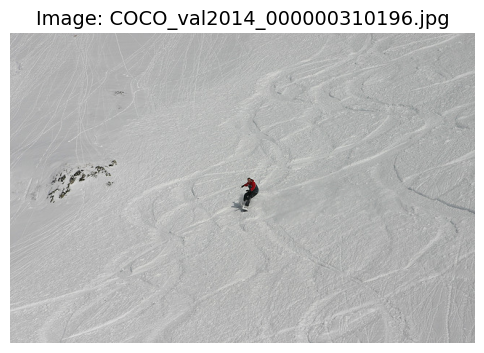

Original Prompt,,Enhanced Prompt
"Prompt: Is there a skis in the image? LLaVA: Yes, there is a skier in the image, and they are wearing skis.",,"Prompt: From the object detector, we can see that, There are 1 helmet, 1 parka, 1 person, and 1 snowboard in the picture. So based on the given information from the object detector and the orginal image, Is there a skis in the image? LLaVA: No, there are no skis in the image. The person is riding a snowboard down the snow-covered slope."


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML
import os

# The data entry
entry = {
    "image": "COCO_val2014_000000310196.jpg",
    "ground_truth": "no",
    "original_prompt": "Is there a skis in the image?",
    "enhanced_prompt": "From the object detector, we can see that, There are 1 helmet, 1 parka, 1 person, and 1 snowboard in the picture. So based on the given information from the object detector and the orginal image, Is there a skis in the image?",
    "llava_result_original": [
      {
        "input_text": [
          {
            "role": "user",
            "content": [
              {
                "type": "image",
                "image": "/content/drive/MyDrive/DINOX-LLAVA/val2014/COCO_val2014_000000310196.jpg"
              },
              {
                "type": "text",
                "text": "Is there a skis in the image?"
              }
            ]
          }
        ],
        "generated_text": " Yes, there is a skier in the image, and they are wearing skis."
      }
    ],
    "llava_result_enhanced": [
      {
        "input_text": [
          {
            "role": "user",
            "content": [
              {
                "type": "image",
                "image": "/content/drive/MyDrive/DINOX-LLAVA/val2014/COCO_val2014_000000310196.jpg"
              },
              {
                "type": "text",
                "text": "From the object detector, we can see that, There are 1 helmet, 1 parka, 1 person, and 1 snowboard in the picture. So based on the given information from the object detector and the orginal image, Is there a skis in the image?"
              }
            ]
          }
        ],
        "generated_text": " No, there are no skis in the image. The person is riding a snowboard down the snow-covered slope."
      }
    ]
}

# Load image path
image_path = entry["llava_result_original"][0]["input_text"][0]["content"][0]["image"]

# Display the image
img = Image.open(image_path)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {os.path.basename(image_path)}", fontsize=14)
plt.show()

# Build HTML for nice printing
html = f"""
<div style="background:#f9f9fa;border-radius:12px;border:1.5px solid #cccccc;padding:20px 25px 16px 25px;width:90%;margin:10px 0;font-size:16px;">
    <b style="color:#6C3483;font-size:18px;">Ground Truth:</b>
    <span style="color:#2874A6;font-weight:bold;">{entry['ground_truth'].upper()}</span><br><br>

    <table style="width:100%;font-size:16px;">
      <tr>
        <th style="width:47%;text-align:left;background:#F4ECF7;padding:8px;border-radius:8px;">Original Prompt</th>
        <th style="width:6%"></th>
        <th style="width:47%;text-align:left;background:#E8F8F5;padding:8px;border-radius:8px;">Enhanced Prompt</th>
      </tr>
      <tr>
        <td style="vertical-align:top;padding:8px 6px 8px 2px;">
            <b>Prompt:</b> {entry['original_prompt']}<br>
            <b style="color:#1D8348;">LLaVA:</b>
            <span style="color:#117A65;">{entry['llava_result_original'][0]['generated_text']}</span>
        </td>
        <td></td>
        <td style="vertical-align:top;padding:8px 2px 8px 6px;">
            <b>Prompt:</b> {entry['enhanced_prompt']}<br>
            <b style="color:#B9770E;">LLaVA:</b>
            <span style="color:#CA6F1E;">{entry['llava_result_enhanced'][0]['generated_text']}</span>
        </td>
      </tr>
    </table>
</div>
"""

display(HTML(html))
